In [3]:
import pyaudio
import wave
import wave
import matplotlib.pyplot as plt
import numpy as np

def record(duration):
    FRAMES_PER_BUFFER = 3200
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 16000

    p = pyaudio.PyAudio()
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=RATE,
        input=True,
        frames_per_buffer=FRAMES_PER_BUFFER
    )

    print('Start recording')
    seconds = duration
    frames = []
    for i in range(0, int(RATE/FRAMES_PER_BUFFER*seconds)):
        data = stream.read(FRAMES_PER_BUFFER)
        frames.append(data)

    print('End recording')
    stream.stop_stream()
    stream.close()
    p.terminate()

    with wave.open("output.wav",'wb') as obj:
        obj.setnchannels(CHANNELS)
        obj.setsampwidth(p.get_sample_size(FORMAT))
        obj.setframerate(RATE)
        obj.writeframes(b"".join(frames))
    return 'output.wav'

def plotgraph(filename):
    with wave.open(filename,'rb') as obj:
        sample_freq = obj.getframerate()
        n_samples = obj.getnframes()
        signal_wave = obj.readframes(-1)

    t_audio = n_samples / sample_freq

    signal_array = np.frombuffer(signal_wave, dtype=np.int16)
    times = np.linspace(0,t_audio,num=len(signal_array))
    plt.figure(figsize=(15,5))
    plt.plot(times, signal_array)
    plt.title("Audio Signal")
    plt.ylabel("Signal wave")
    plt.xlabel("Time (s)")
    plt.xlim(0,t_audio)
    plt.show()


In [11]:
from pydub import AudioSegment
audio = AudioSegment.from_wav("Save.wav")
audio = audio + 6
audio = audio * 2
audio = audio.fade_in(2000)
audio.export("mashup.mp3",format="mp3")
audio2 = AudioSegment.from_mp3("mashup.mp3")
print("done")

done


In [4]:
import requests
from api_secrets import API_KEY_ASSEMBLYAI
import time

def Transcribe_Audio(filepath) -> str :
    headers = {'authorization': API_KEY_ASSEMBLYAI}
    upload_endpoint = "https://api.assemblyai.com/v2/upload"


    def upload(filename, headers):
        def read_file(filename, chunk_size = 5242800):
            with open(filename,'rb') as _file:
                while True:
                    data = _file.read(chunk_size)
                    if not data:
                        break
                    yield data

        upload_response = requests.post(upload_endpoint,headers=headers,data=read_file(filename))
        audio_url = upload_response.json()['upload_url']
        return audio_url

    #transcribe
    def transcribe(audio_url, headers):
        transcript_endpoint = "https://api.assemblyai.com/v2/transcript"
        json = {"audio_url": audio_url}
        transcript_response = requests.post(transcript_endpoint,json=json, headers=headers)
        transcript_id = transcript_response.json()['id']
        return transcript_id

    #poll
    def poll(transcript_id):
        transcript_endpoint = "https://api.assemblyai.com/v2/transcript"
        polling_endpoint =  transcript_endpoint + '/' + transcript_id
        polling_response = requests.get(polling_endpoint, headers=headers)
        return polling_response.json()

    def get_results_url(transcript_id):

        while True:
            data = poll(transcript_id)

            if data['status'] == 'completed':
                return data, None
            elif data['status'] == 'error':
                return data, data['error']
            time.sleep(10)

    #save transcript
    def save(filename, data=None, error=None):
        if data:
            output_filename = filename + ".txt"
            with open(output_filename,'w') as f:
                f.write(data['text'])
            print("Transcription saved")
        else:
            print("Error", error)

    transcript_id = transcribe(upload(filepath,headers),headers)
    data, error = get_results_url(transcript_id)
    if data:
        return data['text']
    elif error:
        return error
    # save(filepath, data, error)




Start recording
End recording
Transcribing...
According to all known laws of aviation, there's no way a bee should be able to fly. Its wings are far too small to get its fat little body off the ground.


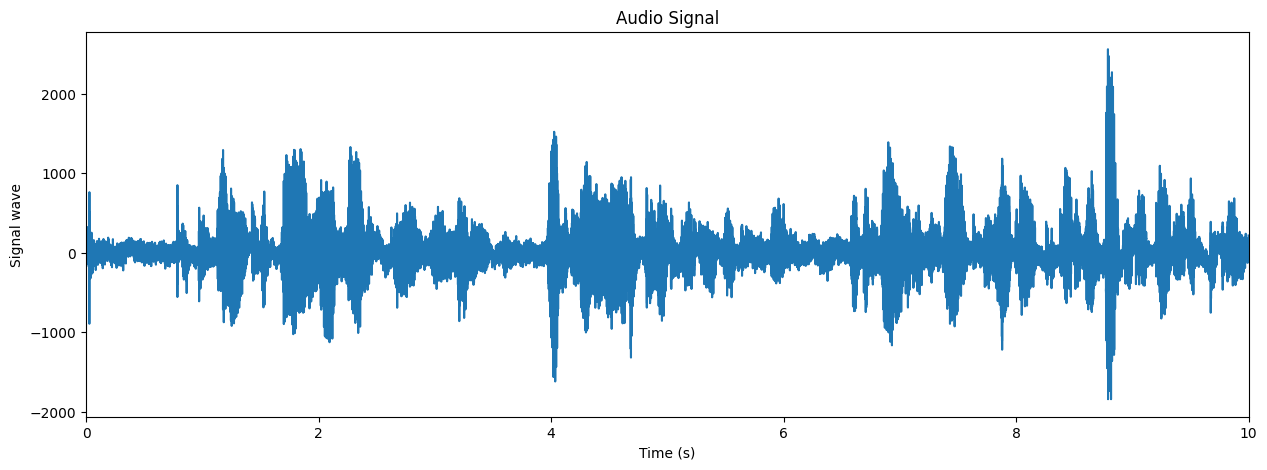

In [14]:
filename = record(10)
print("Transcribing...")
print(Transcribe_Audio(filename))
plotgraph(filename)

In [8]:
from deepgram import Deepgram
import json
from api_secrets import DEEPGRAM_API_KEY

def deepgram(filepath, mimetype='audio/wav'):
    PATH_TO_FILE = filepath
    MIMETYPE = mimetype

    # Initializes the Deepgram SDK
    dg_client = Deepgram(DEEPGRAM_API_KEY)
    
    with open(PATH_TO_FILE, 'rb') as audio:
        source = {'buffer': audio, 'mimetype': MIMETYPE}
        options = { "smart_format": True, "model": "nova-2", "language": "en-US" }

        response = dg_client.transcription.sync_prerecorded(source, options)
        result = response['results']['channels'][0]['alternatives'][0]['transcript']
        return result


In [9]:
filename = record(10)
print("Transcribing...")
print(deepgram(filename))


Start recording
End recording
Transcribing...
Requesting transcript...
Your file may take up to a couple minutes to process.
While you wait, did you know that Deepgram accepts over 40 audio file formats? Even MP4s.
To learn more about customizing your transcripts check out developers.deepgram.com
According to all known laws of aviation, there's no way a bee should be able to fly. Its wings are far too small to get its fat little off the ground.


In [10]:
from deepgram import Deepgram
import asyncio
import aiohttp
from api_secrets import DEEPGRAM_API_KEY
# The API key you created in step 1

# URL for the real-time streaming audio you would like to transcribe
URL = 'http://stream.live.vc.bbcmedia.co.uk/bbc_world_service'

async def main():

    # Initializes the Deepgram SDK
    deepgram = Deepgram(DEEPGRAM_API_KEY)
    # Create a websocket connection to Deepgram
    try:
        deepgramLive = await deepgram.transcription.live(
            { "smart_format": True, "model": "nova-2", "language": "en-US" }
        )
    except Exception as e:
        print(f'Could not open socket: {e}')
        return

    # Listen for the connection to close
    deepgramLive.registerHandler(deepgramLive.event.CLOSE, lambda _: print('Connection closed.'))

    # Listen for any transcripts received from Deepgram and write them to the console
    deepgramLive.registerHandler(deepgramLive.event.TRANSCRIPT_RECEIVED, print)

    # Listen for the connection to open and send streaming audio from the URL to Deepgram
    async with aiohttp.ClientSession() as session:
        async with session.get(URL) as audio:
            while True:
                data = await audio.content.readany()
                deepgramLive.send(data)

                # If no data is being sent from the live stream, then break out of the loop.
                if not data:
                    break

    # Indicate that we've finished sending data by sending the customary zero-byte message to the Deepgram streaming endpoint, and wait until we get back the final summary metadata object
    await deepgramLive.finish()

# asyncio.run(main())

# If you're running this code in a Jupyter notebook, Jupyter is already running an event loop, so you'll need to replace the last line with:
await main()

{'type': 'Results', 'channel_index': [0, 1], 'duration': 3.44, 'start': 0.0, 'is_final': True, 'speech_final': False, 'channel': {'alternatives': [{'transcript': 'As well as filing false tax returns.', 'confidence': 0.9876873, 'words': [{'word': 'as', 'start': 0.39999998, 'end': 0.56, 'confidence': 0.5113181, 'punctuated_word': 'As'}, {'word': 'well', 'start': 0.56, 'end': 0.79999995, 'confidence': 0.99977404, 'punctuated_word': 'well'}, {'word': 'as', 'start': 0.79999995, 'end': 1.28, 'confidence': 0.9997423, 'punctuated_word': 'as'}, {'word': 'filing', 'start': 1.28, 'end': 1.76, 'confidence': 0.8107271, 'punctuated_word': 'filing'}, {'word': 'false', 'start': 1.76, 'end': 2.1599998, 'confidence': 0.99987113, 'punctuated_word': 'false'}, {'word': 'tax', 'start': 2.1599998, 'end': 2.56, 'confidence': 0.9876873, 'punctuated_word': 'tax'}, {'word': 'returns', 'start': 2.56, 'end': 3.06, 'confidence': 0.9246566, 'punctuated_word': 'returns.'}]}]}, 'metadata': {'request_id': 'c2c8fb7f-8a4

CancelledError: 

Task exception was never retrieved
future: <Task finished name='Task-11' coro=<LiveTranscription._receiver() done, defined at c:\Users\kenspoems\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\deepgram\transcription.py:232> exception=ConnectionClosedError(Close(code=1011, reason='Deepgram did not provide a response message within the timeout window. See https://dpgr.am/net0000'), Close(code=1011, reason='Deepgram did not provide a response message within the timeout window. See https://dpgr.am/net0000'), True)>
Traceback (most recent call last):
  File "c:\Users\kenspoems\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\deepgram\transcription.py", line 244, in _receiver
    body = await self._socket.recv()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kenspoems\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\websockets\legacy\protocol.py", line 568, in recv
    await self.ensure_open()
  File "c:\Users\kenspoems\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\websock

{'type': 'Metadata', 'transaction_key': 'deprecated', 'request_id': 'c2c8fb7f-8a45-4eab-a0c4-b273afc75024', 'sha256': 'incomplete', 'created': '2023-12-08T17:21:09.351Z', 'duration': 55.97, 'channels': 1, 'models': ['a10b3ee9-ce40-4aee-8fec-0a190314552c'], 'model_info': {'a10b3ee9-ce40-4aee-8fec-0a190314552c': {'name': '2-general-nova', 'version': '2023-11-14.3451', 'arch': 'nova-2'}}}
Connection closed.


None
